In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import numpy as np


/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'dlopen(/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN3c1017RegisterOperatorsD1Ev
  Referenced from: <CFED5F8E-EC3F-36FD-AAA3-2C6C7F8D3DD9> /opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torchvision/image.so
  Expected in:     <00557156-D9ED-3787-A566-D69231F4CE54> /opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/torch/lib/libtorch_cpu.dylib'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
# Define HyperParameters 
input_size = 28*28 # image total pixel 
batch_size = 100
learning_rate = 1E-2
num_epochs = 5

# Set Device to MPS 
device = torch.device("mps")

In [4]:
# Load MNIST data
# MNIST dataset (images and labels)
train_dataset = torchvision.datasets.MNIST(root='../../data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

# Data loader (input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)


# Download and load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(root='../../data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

# Create a data loader for the test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [5]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(True),
            nn.Linear(256, 64),
            nn.ReLU(True),
            nn.Linear(64, 32),
            nn.ReLU(True),
            nn.Linear(32, 16)
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
# Use AE mdoel for training 
autoencoder = AutoEncoder().to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)


In [7]:
for epoch in range(num_epochs):
    for data in train_loader:
        images, _ = data
        images = images.view(images.size(0), -1).to(device)
        optimizer.zero_grad()
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()

    print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, loss.item()))

Epoch [1/5], Loss: 0.0349
Epoch [2/5], Loss: 0.0337
Epoch [3/5], Loss: 0.0277
Epoch [4/5], Loss: 0.0252
Epoch [5/5], Loss: 0.0248


In [8]:
autoencoder.eval()
total_loss = 0
with torch.no_grad():
    for data in test_loader:
        images, _ = data
        images = images.view(images.size(0), -1).to(device)
        outputs = autoencoder(images)
        loss = criterion(outputs, images)
        total_loss += loss.item()

average_loss = total_loss / len(test_loader)
print("Average Test Loss: {:.4f}".format(average_loss))

Average Test Loss: 0.0233


In [22]:
# Set the autoencoder model to evaluation mode
autoencoder.eval()

# Choose a batch of test images
images, _ = next(iter(test_loader))

# Move the chosen test images to the GPU (if using CUDA)
images = images.to(device)

# Perform the forward pass through the autoencoder to obtain the reconstructed images
with torch.no_grad():
    reconstructed_images = autoencoder(images.view(images.size(0), -1))

In [10]:
# Move the reconstructed images back to the CPU (if using CUDA)
reconstructed_images = reconstructed_images.cpu()

In [11]:
reconstructed_images.shape

torch.Size([100, 784])

Text(0.5, 1.0, 'Reconstructed')

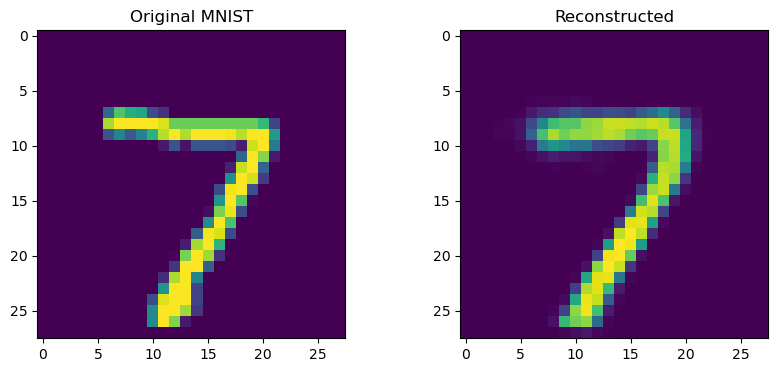

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

# Plot the first subplot
axes[0].imshow(images[0].reshape((28,28)).cpu())
axes[0].set_title('Original MNIST')

# Plot the second subplot
axes[1].imshow(reconstructed_images[0].reshape((28,28)))
axes[1].set_title('Reconstructed')
